# Dermoscopic Skin Lesion Image Classifier

This notebook walks through the steps needed to create a Convolutional Neural Network to classify dermoscopic skin lesion images. The CNN was trained using the HAM10000 dataset, along with some data augmentation to attempt to remedy the problem of imbalanced classes within the aforementioned dataset.

To view the exploratory data analysis done on this dataset, my notebook publicly available [here](https://github.com/hasib-a/ham10000_exploratory_data_analysis/blob/master/exploratory-data-analysis-ham10000.ipynb).

The dataset is publicly available to download over at [Harvard Dataverse](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBW86T).

This CNN model will attempt to detect 7 different classes of skin cancer:
- Actinic keratoses
- Basal cell carcinoma
- Benign keratosis
- Dermatofibroma
- Melanoma
- Melanocytic nevi
- Vascular lesions

#### HAM10000 Dataset
The HAM10000 dataset includes a representative collection of all important diagnostic categories in the realm of pigmented lesions: Actinic keratoses and intraepithelial carcinoma / Bowen's disease (akiec), basal cell carcinoma (bcc), benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, bkl), dermatofibroma (df), melanoma (mel), melanocytic nevi (nv) and vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, vasc).

In [92]:
# all imports needed here
from glob import glob
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
import pickle
import h5py


import keras
from keras.utils.np_utils import to_categorical # to allow us to convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Dropout, Flatten
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator


In [7]:
base_directory = '/home/ah2020/skin_lesion_classification/ham10000_dataset'

# create dict of image path
files_list = glob('/home/ah2020/skin_lesion_classification/ham10000_dataset/*.jpg')

img_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in files_list}

# Categories of the diferent skin lesions
lesion_types_dict = {
    'akiec': 'Actinic keratoses',
    'bcc': 'Basal cell carcinoma',
    'bkl': 'Benign keratosis',
    'df': 'Dermatofibroma',
    'mel': 'Melanoma',
    'nv': 'Melanocytic nevi',
    'vasc': 'Vascular lesions',
}

### Read in and process data

Now to read in the metadata CSV file by using pandas. Then creation of new columns for readability purposes later in the notebook.

- cell_type has the human readable name of the lesion
- cell_type_idx categorises the lesion types into codes from 0-6

In [9]:
df = pd.read_csv(os.path.join(base_directory, 'HAM10000_metadata.csv'))

# creation of new columns for readability later
df['path'] = df['image_id'].map(img_path_dict.get)
df['cell_type'] = df['dx'].map(lesion_types_dict.get) 
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes

In [10]:
df['age'].fillna((df['age'].mean()), inplace=True) # because None values not supported.

### Resize the images

Images to be loaded into the dataframe at column 'image' from the image path, then resize the images to 100x75 as TensorFlow caannot handle the original image dimesions (450x600x3)

In [11]:
# already ran this before
df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

In [12]:
df['image'].map(lambda x: x.shape).value_counts()

(75, 100, 3)    10015
Name: image, dtype: int64

In [13]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/home/ah2020/skin_lesion_classification/ham100...,Benign keratosis,2,"[[[191, 153, 194], [191, 154, 198], [189, 152,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/home/ah2020/skin_lesion_classification/ham100...,Benign keratosis,2,"[[[23, 13, 22], [25, 15, 24], [24, 16, 31], [3..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/home/ah2020/skin_lesion_classification/ham100...,Benign keratosis,2,"[[[186, 126, 136], [190, 136, 149], [195, 137,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/home/ah2020/skin_lesion_classification/ham100...,Benign keratosis,2,"[[[24, 11, 18], [27, 13, 26], [39, 23, 33], [6..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/home/ah2020/skin_lesion_classification/ham100...,Benign keratosis,2,"[[[136, 91, 114], [148, 104, 127], [161, 117, ..."


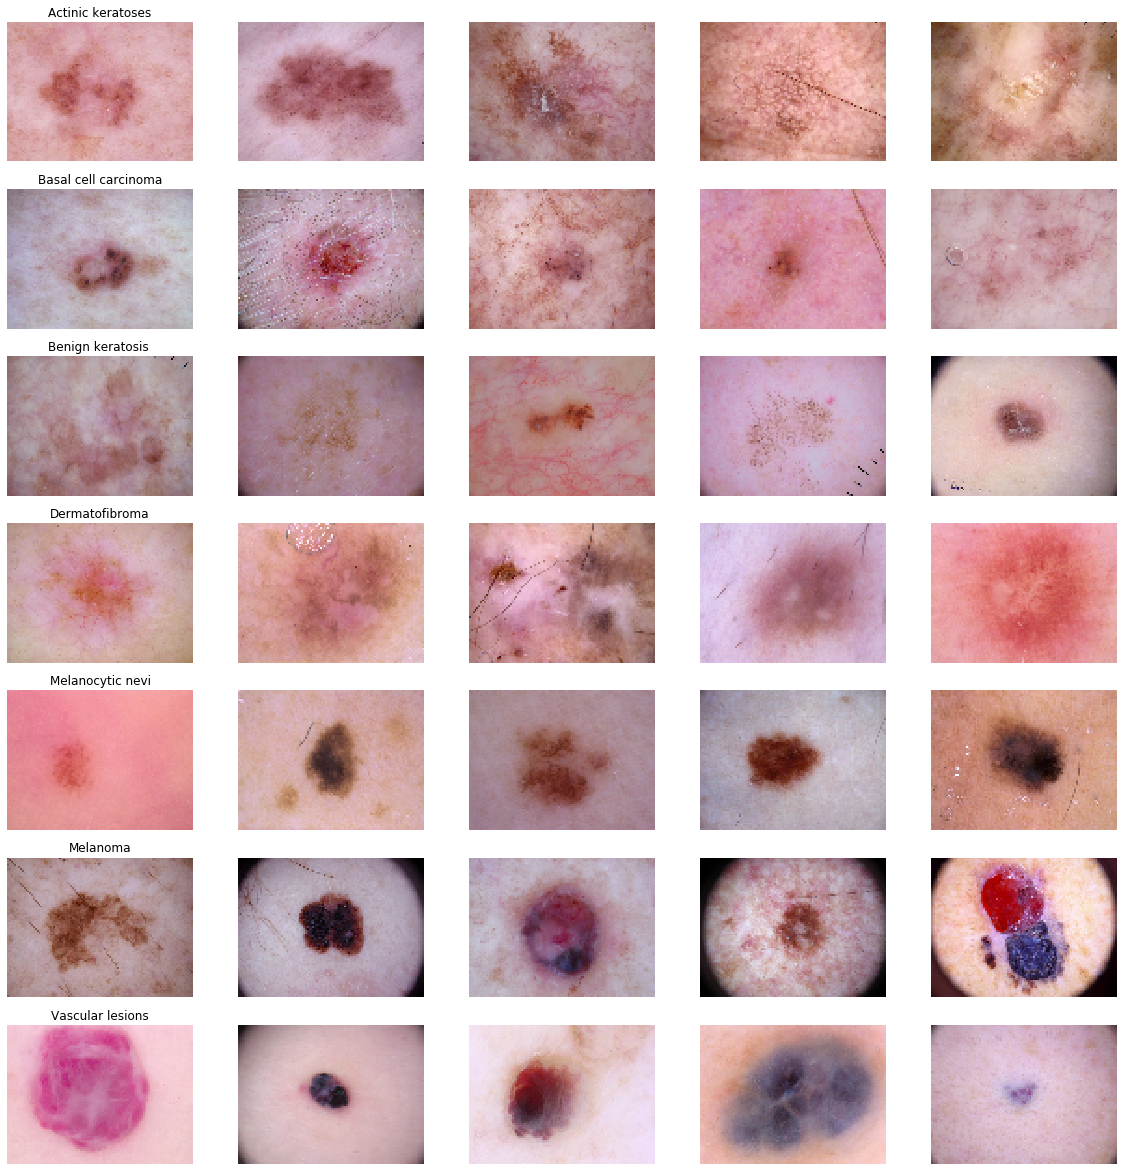

In [17]:
samples = 5
fig, m_axes = plt.subplots(7, samples, figsize = (4*samples, 3*7))
for n_axes, (type_name, type_rows) in zip(m_axes, 
                                         df.sort_values(['cell_type']).groupby('cell_type')):
    n_axes[0].set_title(type_name)
    for col_ax, (_, c_row) in zip(n_axes, type_rows.sample(samples, random_state=100).iterrows()):
        col_ax.imshow(c_row['image'])
        col_ax.axis('off')
fig.savefig('category_lesion_samples.png', dpi=450)

### Create the feature set and labels

In [18]:
features=df.drop(columns=['cell_type_idx'],axis=1)
labels=df['cell_type_idx']

### Training and testing split

Splitting the dataset into 80% training and 20% testing


In [19]:
x_train_, x_test_, y_train_, y_test_ = train_test_split(features, labels, test_size=0.20,random_state=1234)

### Normalise features

Normalisation of the x_train & x_test by the following method:


(x_train - x_train_mean) / x_train_std_dev

(x_test - x_test_mean) / x_test_std_dev

In [20]:
x_train = np.asarray(x_train_['image'].tolist())
x_test = np.asarray(x_test_['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

We have 7 classes (skin lesion types from 0-6) and using a binary loss this will not work.

To allow me to use a binary loss, I will have to create one-hot vectors from the class indices as per [keras docs](ps://www.tensorflow.org/guide/keras/train_and_evaluate)

In [24]:
# Creating one-hot vectors on the class indices
y_train = to_categorical(y_train_, num_classes = 7)
y_test = to_categorical(y_test_, num_classes = 7)

### Create validation set

I have chosen a 90/10 split on the training set; 90% to train the model and 10% to be used for a validation set which the model will be evaluated by.

In [25]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, 
                                                            test_size = 0.1, 
                                                            random_state = 2)
# setting random_state to 2 for reproducability, rather than the default RandomState instance used by np.random

### Create the CNN model

Creation of the CNN model using the Keras Sequential API, adding one layer at a time, with the input being the first layer.

In [26]:
num_classes = 7

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=(75, 100, 3)))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 75, 100, 32)       896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 100, 32)       9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 50, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 37, 50, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 50, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 37, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 25, 64)       

### Compile model

In [28]:
model.compile(optimizer = 'adam' , loss = "categorical_crossentropy", metrics=["accuracy"])

### Setting a learning rate annealer

To allow the optimiser to converge faster and get as close to the global min of the loss function, I have implemented a simulated annealing method of the learning rate.

Learning rate here refers to the step that the optimiser walks through the "loss landscape". The higher the learning rate the bigger the steps and this means quicker convergence. High learning rate also offers fast computation time when compared to a comparatively lower learning rate. It is important to note however that a higher learning rate results in poor sampling.

I have used a decreasing learning rate during the trainign of the CNN to allow it to reach the global minimum of the loss function. I started with a high learning rate, then decreased the learning rate dynamically every X epochs (steps) if the accuracy did not improve.

Using the function ReduceLROnPlateau() from keras.callbacks, I opted to reduce the learning rate by a quater (25%) if the accuracy did not improve after 3 epochs. 


In [34]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.25, 
                                            min_lr=0.00001)

### Data augmentation

Following the exploratory data analysis I did on the dataset, I indentified the need to artifically expand the HAM10000 dataset in order to avoid the model overfitting.

This essentially makes the dataset larger, altering the training data with minor transformations to produce variations within the images. Artifically making the dataset larger results in more training data which will enable me to create a more robust model.

For this data augmentation I chose to:
- rotate some images by 30 degrees randomly
- zoom some images by 20% randomly
- shift some of the images horizontally by 20% randomly
- shift some of the images vertically by 20% randomly
- flip some images horizontally
- flip some images vertically

More augmentations can be done with the ImageDataGenerator() for more variability within the training dataset if needed in the future.

In [39]:
datagen = ImageDataGenerator(
        rotation_range=30,  # rotate images between 0-180 degrees randomly
        zoom_range = 0.2, # zoom image randomly
        width_shift_range=0.2,  # shift images horizontally (the input is a fraction of total width) randomly
        height_shift_range=0.2,  # shift images vertically (thei nput is a fraction of total height) randomly
        horizontal_flip=True,  # flip images horizontally randomly
        vertical_flip=True)  # flip images vertically randomly

datagen.fit(x_train)

### Fit the model

Fit x_train, y_train to the model. I have decided on a batch size of 15, as a smaller batch size can be more efficient in training the model and I have chosen 50 epochs to allow the model ample time time to train.

In [40]:
batch_size = 15
epochs = 50 
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1)

Epoch 1/50
481/481 [==============================] - 50s 103ms/step - loss: 1.0620 - accuracy: 0.6644 - val_loss: 0.9114 - val_accuracy: 0.6808
Epoch 2/50
481/481 [==============================] - 49s 102ms/step - loss: 0.9507 - accuracy: 0.6692 - val_loss: 0.9042 - val_accuracy: 0.6820
Epoch 3/50
481/481 [==============================] - 50s 103ms/step - loss: 0.9142 - accuracy: 0.6691 - val_loss: 0.8397 - val_accuracy: 0.6858
Epoch 4/50
481/481 [==============================] - 49s 101ms/step - loss: 0.8852 - accuracy: 0.6770 - val_loss: 0.8591 - val_accuracy: 0.6958
Epoch 5/50
481/481 [==============================] - 48s 100ms/step - loss: 0.8662 - accuracy: 0.6832 - val_loss: 0.8388 - val_accuracy: 0.7007
Epoch 6/50
481/481 [==============================] - 48s 101ms/step - loss: 0.8439 - accuracy: 0.6943 - val_loss: 0.7994 - val_accuracy: 0.7195
Epoch 7/50
481/481 [==============================] - 49s 101ms/step - loss: 0.8409 - accuracy: 0.6954 - val_loss: 0.8073 - val_ac

### Export model

In [87]:
model.save('skin_lesion_image_classifier.h5') # saves file as a HDF5 file, Saving/loading whole models (architecture + weights + optimizer state)

### Evaluate model performance

In [41]:
print('history dict:', history.history)

history dict: {'val_loss': [0.9113508864605516, 0.9041735430310789, 0.8397465612451335, 0.8591034550990845, 0.8388134825259372, 0.799377977364973, 0.8073152982237333, 0.7399733775200095, 0.7261049893505853, 0.7411495257271198, 0.7537276912062543, 0.7405035687503672, 0.7561278630261706, 0.7047272353175275, 0.6654687497829855, 0.7117433540541632, 0.6897998663998601, 0.7053591004036311, 0.6495915123835169, 0.6915735016365598, 0.6555733742410702, 0.6623599193339931, 0.6866477484491995, 0.6477428288977045, 0.643185944071137, 0.6634350869423731, 0.6432086327055149, 0.6839500217143437, 0.6567713097666862, 0.666514939723764, 0.6661886996461863, 0.6522456812219429, 0.6260261107561297, 0.6320008272467706, 0.6662230351544972, 0.6790553970898773, 0.6747630547704245, 0.6522278823422969, 0.6116760909334382, 0.6704198770838188, 0.6662144615242903, 0.633313424829533, 0.6319135441595777, 0.6978891460675551, 0.6493535343362506, 0.6841205360363249, 0.6437519984203681, 0.6396151244863311, 0.64062991745751

In [43]:
# Evaluate the model on the test data using `evaluate`
print('\n# Evaluate on test data')
results = model.evaluate(x_test, y_test, batch_size=128)
print('test loss, test acc:', results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print('\n# Generate predictions for 3 samples')
predictions = model.predict(x_test[:3])
print('predictions shape:', predictions.shape)



# Evaluate on test data
2003/2003 [==============================] - 2s 937us/step
test loss, test acc: [0.7072022269799361, 0.7423864006996155]

# Generate predictions for 3 samples
predictions shape: (3, 7)


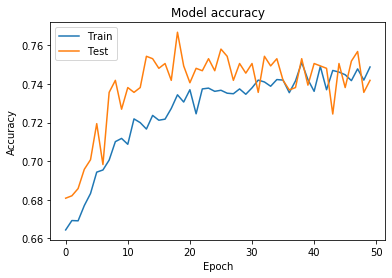

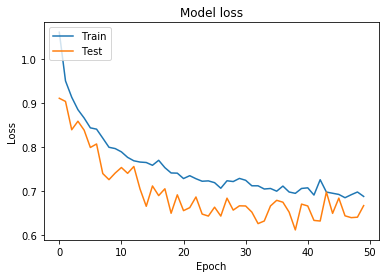

In [60]:
# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

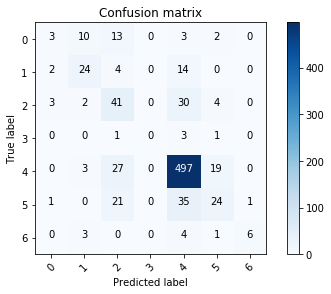

<Figure size 1080x1080 with 0 Axes>

In [84]:
# Function to plot confusion matrix    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.figure(figsize=(15,15))

# Predict the values from the validation dataset
Y_pred = model.predict(x_validate)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validate,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 

### Check which categories had the most incorrect predictions

Text(0, 0.5, 'Fraction of Incorrect Classifications')

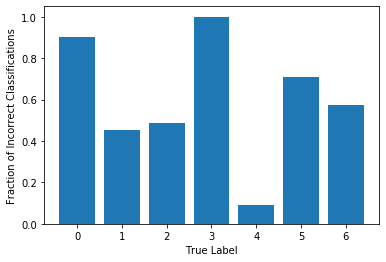

In [93]:
label_fraction_err = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(7),label_fraction_err)
plt.xlabel('True Label')
plt.ylabel('Fraction of Incorrect Classifications')



### Incorrect classification results

As we can see from the plot above, the model has the most incorrect predictions for 

The top 3 incorrect predictions:
- Dematofibroma (class 3)
- Actinic keratosis (class 0)
- Melanocytic nevi (class 5)

The model had the least incorrect predictions for Melanoma (class 4), which is to be assumed as it had the the most images for that particular skin lesion in our dataset.


Table below for reference on the code -> skin lesion name

|Lesion Name |  Code|
|--|--|
| Actinic keratoses | 0 |
| Basal cell carcinoma | 1 |
| Benign keratosis | 2 |
| Dermatofibroma | 3 |
| Melanoma | 4 |
| Melanocytic nevi | 5 |
| Vascular lesion | 6 |



